# MCMC with Python / NumPy / Scipy.stats

Code shamelessly stolen and adapted from Tom Wiecki's blog, [**While my MCMC Gently Samples**](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/)

Other resources and Python libraries:
* [PyMC3](https://pymc-devs.github.io/pymc3/index.html) -- Bayesian statistical modeling and Probabilistic Machine Learning package which focuses on advanced Markov chain Monte Carlo and variational fitting algorithms.
* [emcee -- the MCMC Hammer](http://dan.iel.fm/emcee/current/) -- The Python ensemble sampling toolkit for affine-invariant MCMC.
* [Edward](http://edwardlib.org/) -- Python library for probabilistic modeling, inference, and criticism that fuses three fields: Bayesian statistics and machine learning, deep learning, and probabilistic programming.

Our goals in this section are very modest: we will start with a simple pure-Python MCMC sampler for a very simple Bayesian model and progressively improve its performance with Cython.

The core goal is to demonstrate advanced Cython capabilites in the context of Bayesian statistical modeling.

An ancilliary goal is to better understand the inner workings of MCMC samplers for Bayesian modeling, in the spirit of Feynman:

_"What I cannot create, I do not understand."_

The algorithm used here is very simple; there are much more sophisticated and efficient MCMC algorithms implemented in the packages above.  If you're doing things for real, then you should be using them.

In [3]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

np.random.seed(123)

## Data sampled from standard normal

Our goal will be to estimate the posterior of the mean $\mu$ assuming that we know the standard deviation $\sigma$ to be 1.

In [4]:
data = np.random.randn(20)

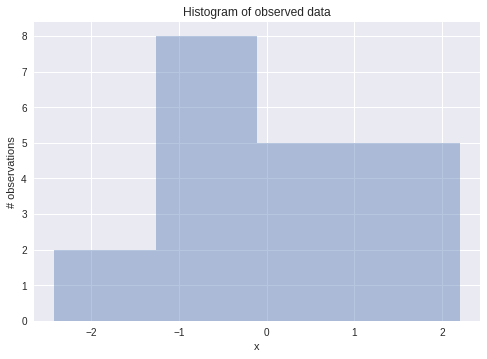

In [5]:
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

## Define our model

Normals everywhere!

Prior distribution on $\mu$:

$$p(\mu) = N(0, 1)$$

Likelihood:

$$p(x|\mu) = N(x | \mu, 1)$$

For this simple model, we can analytically compute our posterior:

$$p(\mu|x) = N(\mu | \mu_p, \sigma_p)$$

where

$$ \frac{1}{\sigma_p^2} = \frac{1}{\sigma_0^2} + \frac{n}{\sigma^2} $$

and 

$$ \mu_p = \frac{\frac{\mu_0}{\sigma_0^2} + \frac{n \bar{x}}{\sigma^2}}{\sigma_p^2} $$

In [6]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

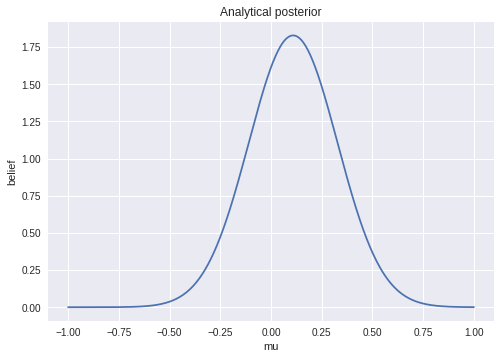

In [7]:
ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

## MCMC Sampler

We want to generate samples from an unnormalized distribution that's proportional to the posterior given by Bayes' Theorem:

$$p(\mu|x) \propto p(x|\mu) p(\mu)$$

The [basic MCMC algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) proceeds as follows:

1. We're given an initial value for $\mu_{current}$.
1. We sample a proposed $\mu_{prop}$ from a proposal distribution for $\mu \sim N(\mu|\mu_{current}, \sigma_{prop})$.
1. We compute the likelihood of our data, $x$, given $\mu_{prop}$, $p(x|\mu_{prop})$.
1. We then compute an acceptance probability as the following ratio:
$$ p_{accept} = \frac{p(x|\mu_{prop}) p(\mu_{prop})}{p(x|\mu_{current})p(\mu_{current})}$$
1. We assign $\mu_{current} = \mu_{prop}$ with probability:
$$\min(1, p_{accept})$$
otherwise $\mu_{current}$ remains unchanged.
1. We repeat these steps many times, and generate a sequence of values for $\mu$ sampled from the posterior distribution.

There are many, many improvments on this base MCMC algorithm to make it more efficient.

In [9]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

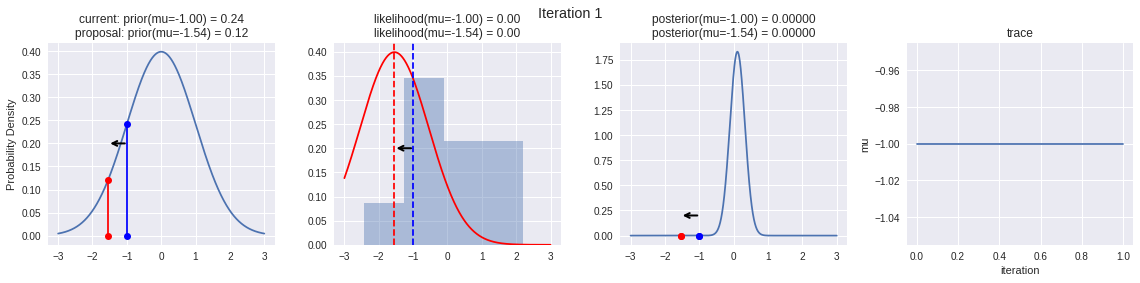

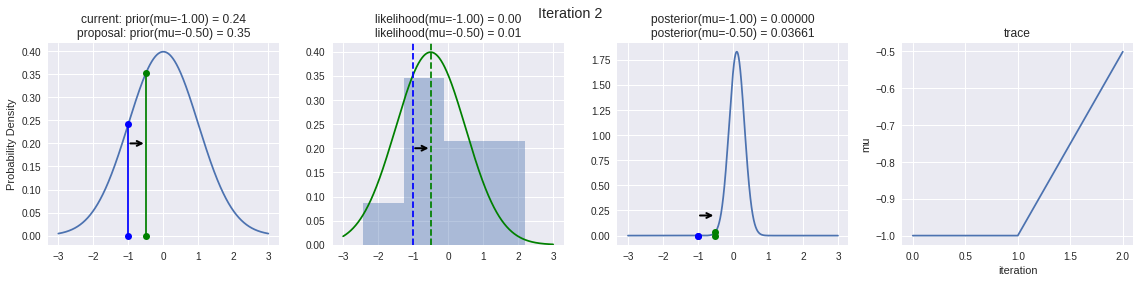

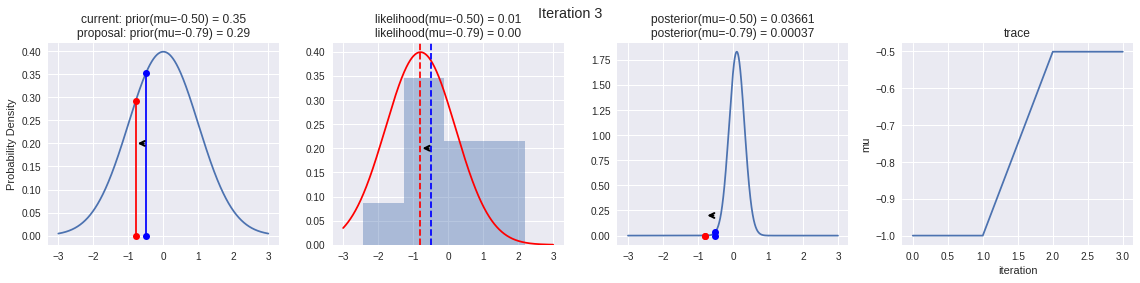

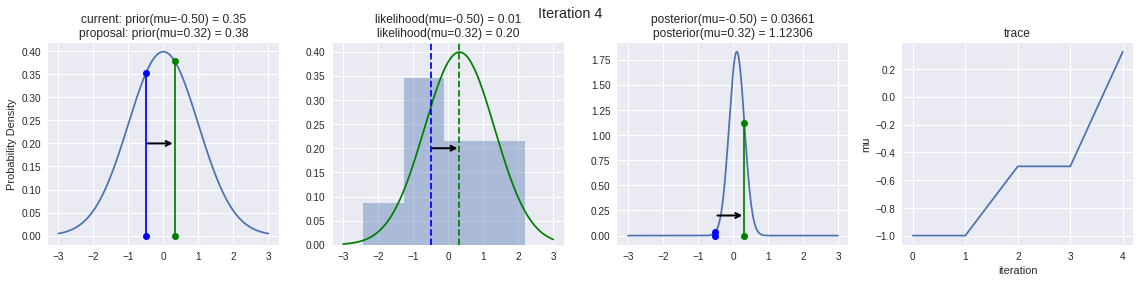

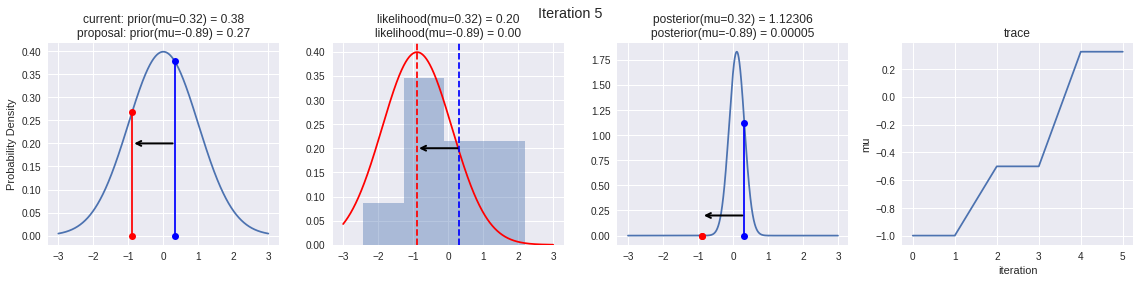

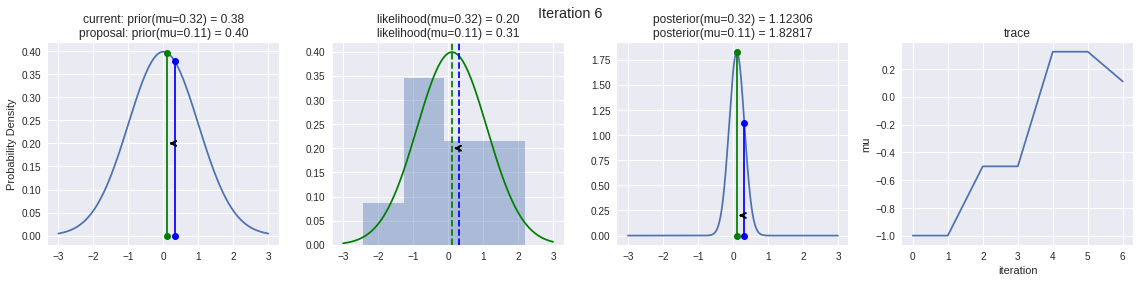

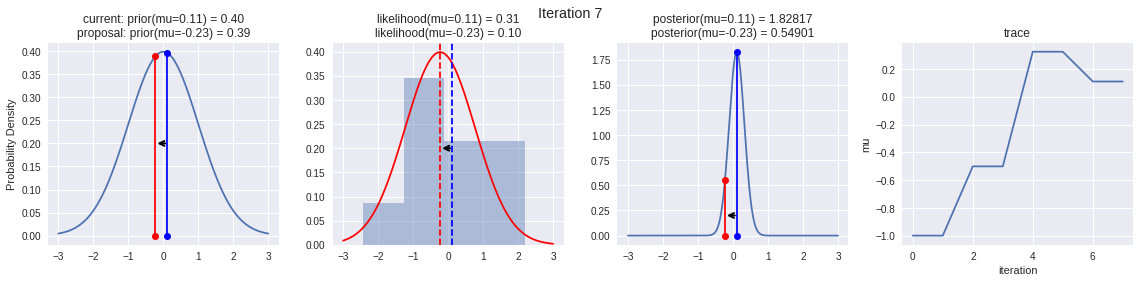

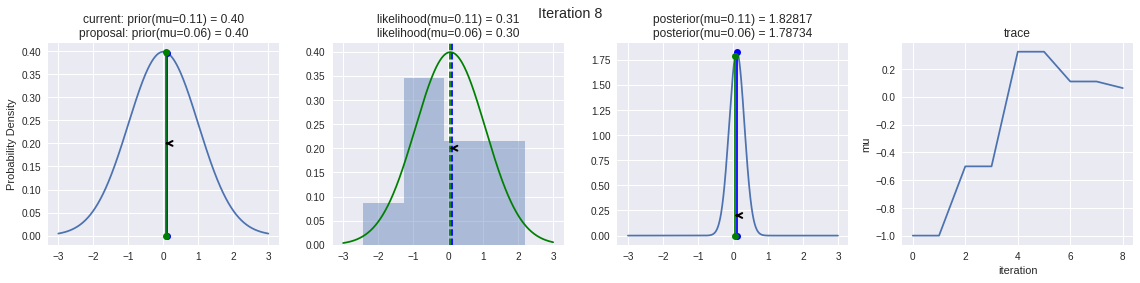

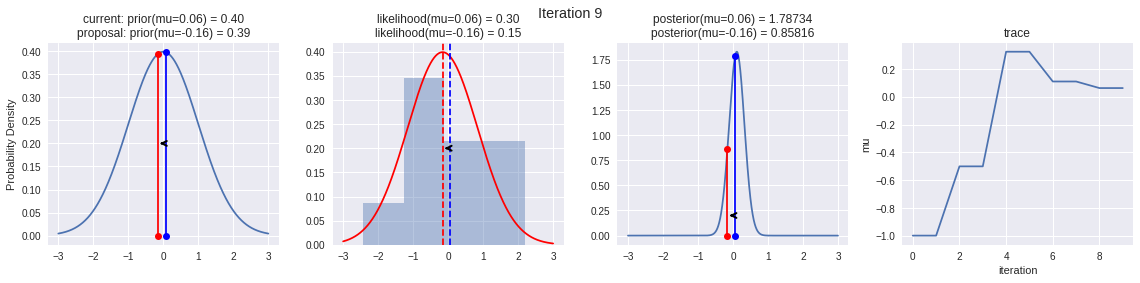

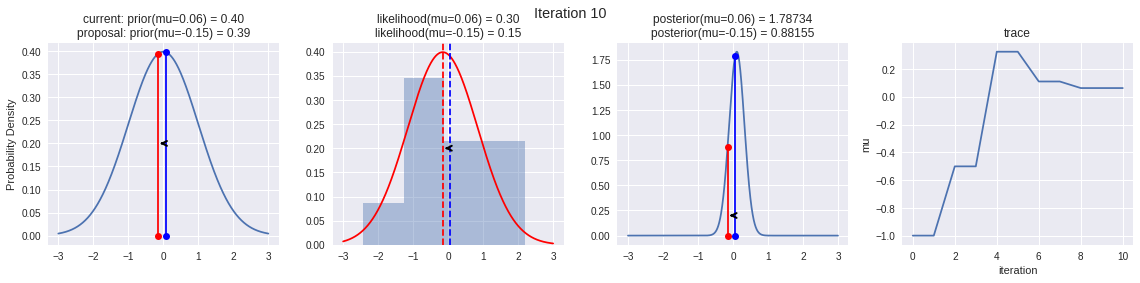

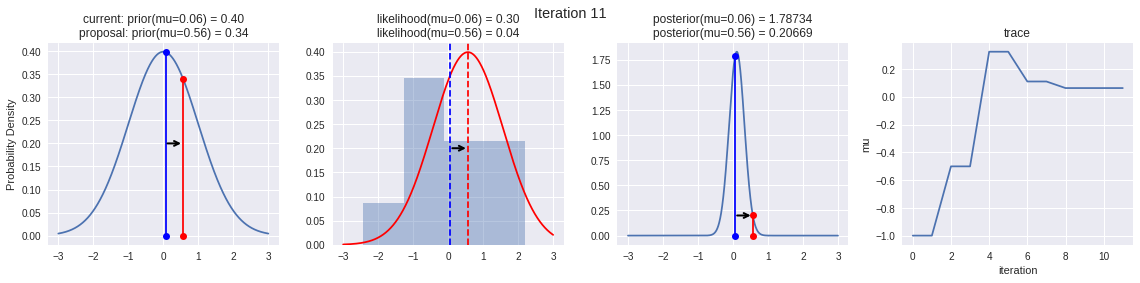

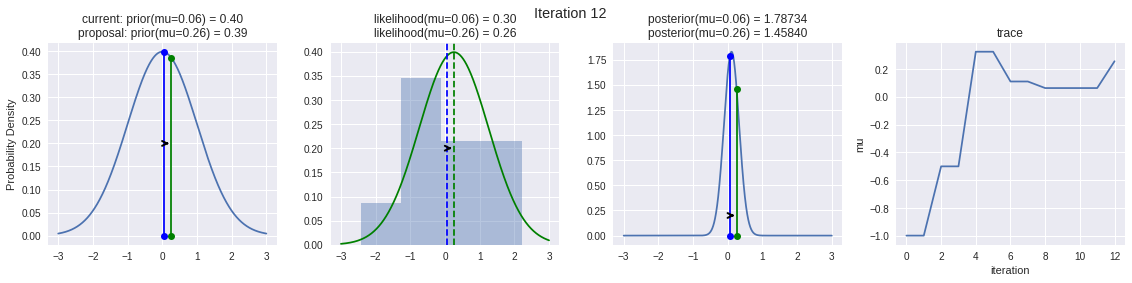

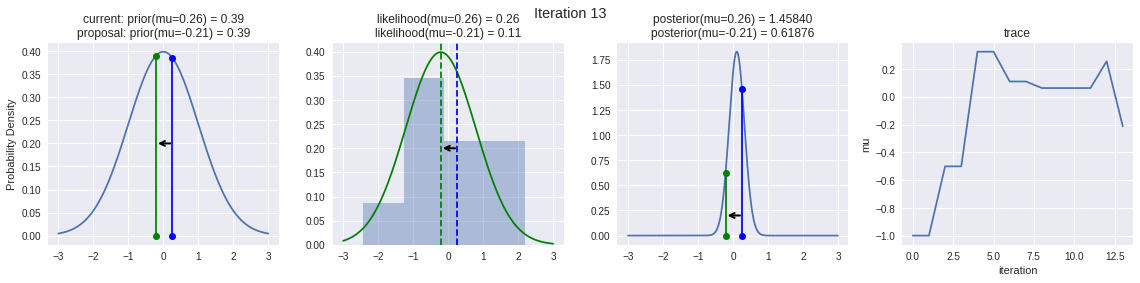

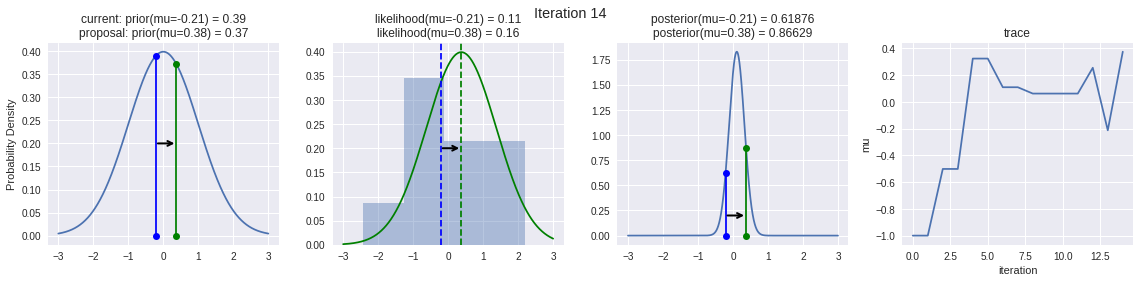

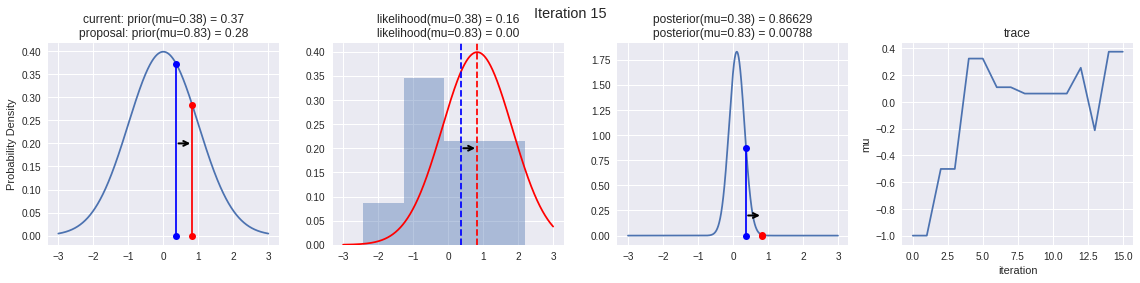

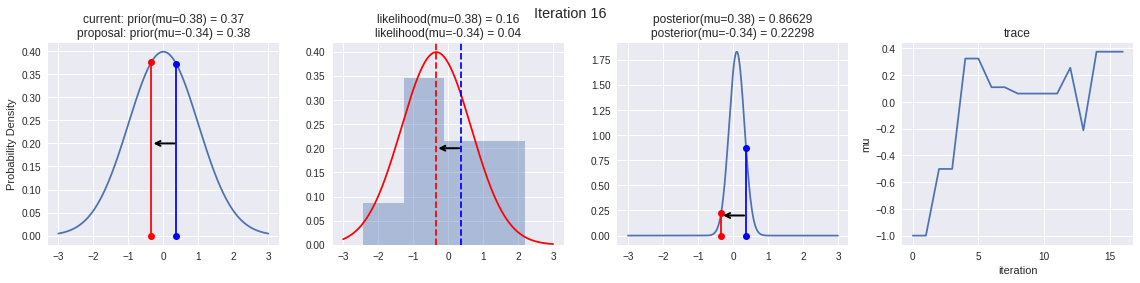

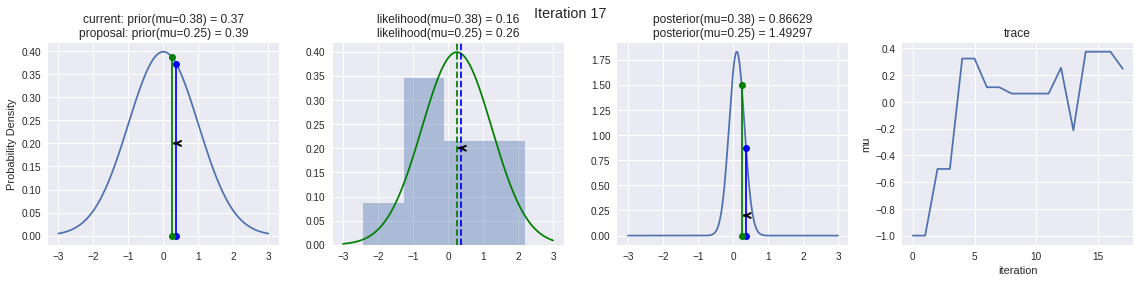

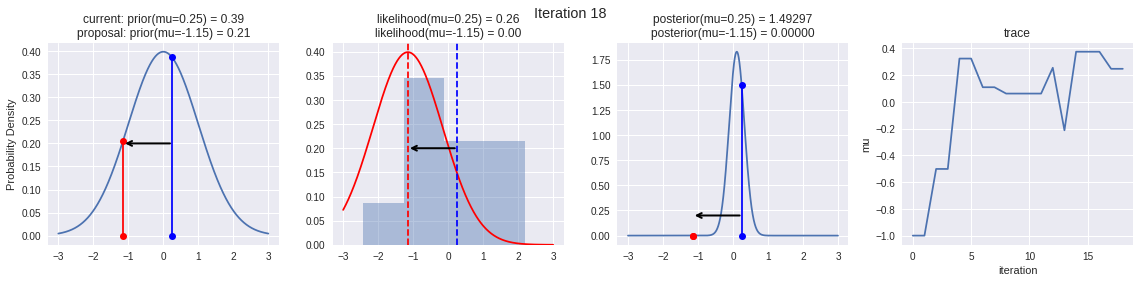

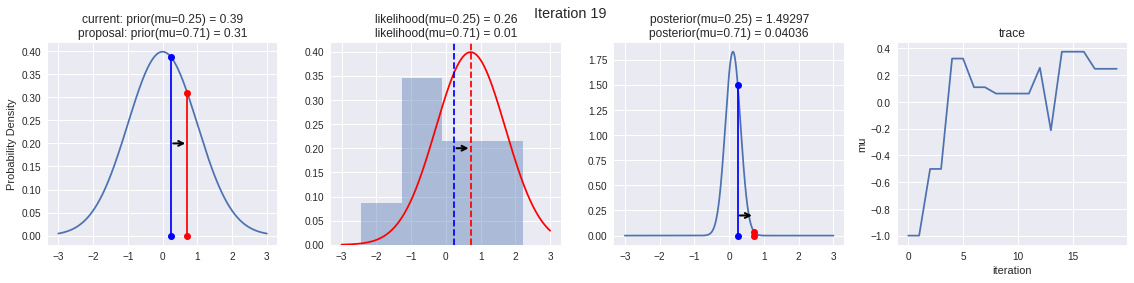

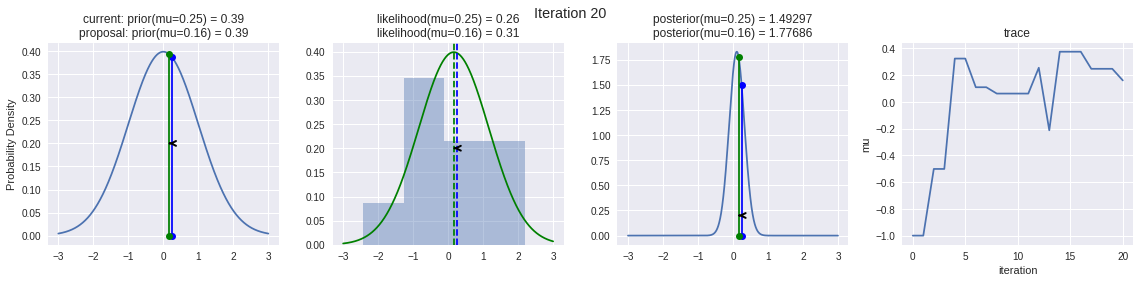

In [10]:
np.random.seed(123)
sampler(data, samples=20, mu_init=-1., plot=True);

CPU times: user 53.9 s, sys: 0 ns, total: 53.9 s
Wall time: 53.9 s


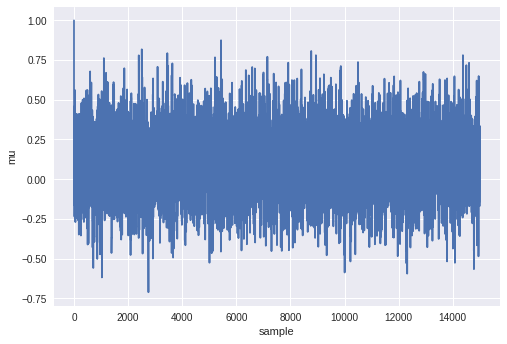

In [11]:
%%time
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

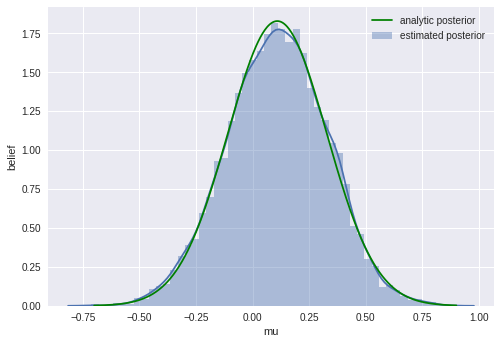

In [12]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.7, .9, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();